In [31]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
# Load the provided datasets
df2021 = pd.read_csv('../data/shelter/daily-shelter-overnight-service-occupancy-capacity-2021.csv')
df2022 = pd.read_csv('../data/shelter/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
df2023 = pd.read_csv('../data/shelter/daily-shelter-overnight-occupancy.csv')

df2022['OCCUPANCY_DATE'] = pd.to_datetime(df2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
df2021['OCCUPANCY_DATE'] = pd.to_datetime(df2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')

# Combine the datasets for 2021 and 2022
df = pd.concat([df2021, df2022])
df_1103 = df[df['LOCATION_ID'] == 1103]

# Aggregate the combined data by OCCUPANCY_DATE to get the total SERVICE_USER_COUNT for each date
aggregated_overall_users = df_1103.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()

# Convert the index to datetime format
aggregated_overall_users.index = pd.to_datetime(aggregated_overall_users.index, format='%Y-%m-%d')
aggregated_overall_users.sort_index(inplace=True)

# Display the first few rows of the aggregated data
aggregated_overall_users.head()


OCCUPANCY_DATE
2021-01-01    242
2021-01-02    245
2021-01-03    248
2021-01-04    259
2021-01-05    268
Name: SERVICE_USER_COUNT, dtype: int64

In [33]:
# Combine the datasets for 2021, 2022, 2023
combined_df = pd.concat([df2021, df2022, df2023])
combined_1103 = combined_df[combined_df['LOCATION_ID'] == 1103]

# Aggregate the combined data by OCCUPANCY_DATE to get the total SERVICE_USER_COUNT for each date
aggregated_overall_users_all_years = combined_1103.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()

# Convert the index to datetime format
aggregated_overall_users_all_years.index = pd.to_datetime(aggregated_overall_users_all_years.index, format='%Y-%m-%d')
aggregated_overall_users_all_years.sort_index(inplace=True)

/opt/miniconda3/envs/data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


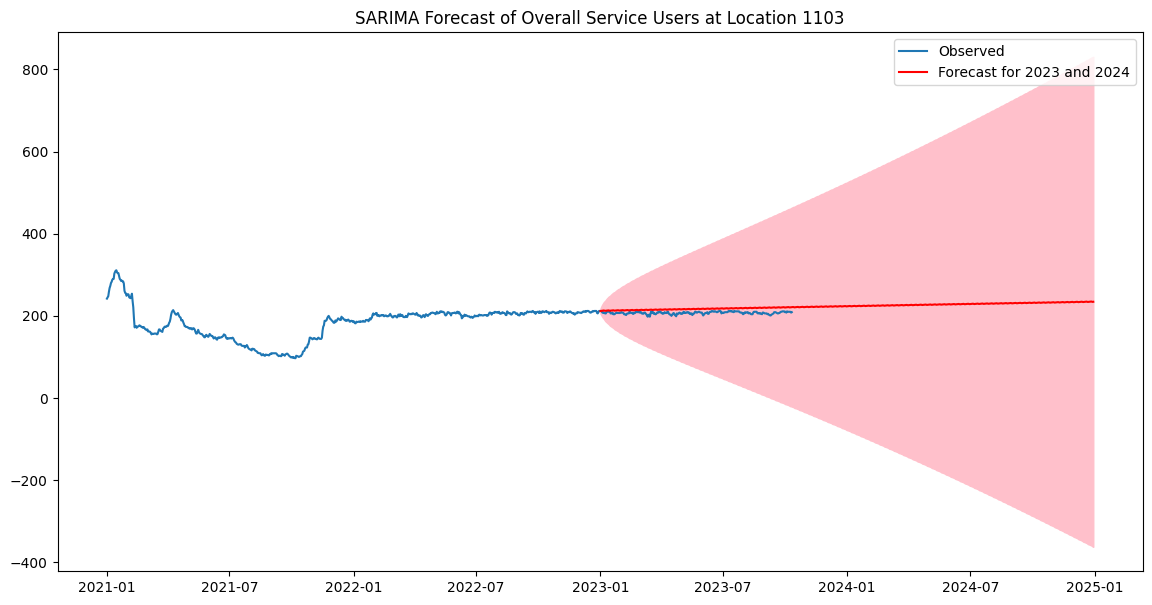

In [37]:
# Define a SARIMA model for the aggregated time series data
# The order parameter specifies the AR, differencing, and MA terms, respectively.
# The seasonal_order parameter adds seasonal terms with a weekly periodicity (specified as 7).
model_overall_users = SARIMAX(aggregated_overall_users, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality assumed

# Fit the SARIMA model to the data.
# The disp=False argument suppresses convergence output for cleaner presentation.
sarima_overall_users_result = model_overall_users.fit(disp=False)

# Forecast the service users for the next 730 days (covering 2023 and 2024).
forecast_overall_users = sarima_overall_users_result.get_forecast(steps=730)

# Extract the mean forecast values from the forecast results.
mean_forecast_overall_users = forecast_overall_users.predicted_mean

# Extract the confidence intervals for the forecast. 
# This provides an upper and lower bound for the forecast, indicating the uncertainty.
confidence_intervals_overall_users = forecast_overall_users.conf_int()

# Set up the figure and axis for plotting with a specified size.
plt.figure(figsize=(14, 7))

# Plot the observed data in blue.
plt.plot(aggregated_overall_users_all_years.index, aggregated_overall_users_all_years, label='Observed')

# Plot the forecasted data in red.
plt.plot(mean_forecast_overall_users.index, mean_forecast_overall_users, color='red', label='Forecast for 2023 and 2024')

# Fill the area between the upper and lower confidence intervals with pink to indicate uncertainty.
plt.fill_between(confidence_intervals_overall_users.index, 
                 confidence_intervals_overall_users.iloc[:, 0], 
                 confidence_intervals_overall_users.iloc[:, 1], color='pink')

# Add a legend to the plot for clarity.
plt.legend()

# Add a title to the plot.
plt.title('SARIMA Forecast of Overall Service Users at Location 1103')

# Display the plot.
plt.show()

In [38]:
df_1051 = df[df['LOCATION_ID'] == 1051]

# Aggregate the combined data by OCCUPANCY_DATE to get the total SERVICE_USER_COUNT for each date
aggregated_overall_users = df_1051.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()

# Convert the index to datetime format
aggregated_overall_users.index = pd.to_datetime(aggregated_overall_users.index, format='%Y-%m-%d')
aggregated_overall_users.sort_index(inplace=True)

# Display the first few rows of the aggregated data
aggregated_overall_users.head()

OCCUPANCY_DATE
2021-01-01    6
2021-01-02    6
2021-01-03    6
2021-01-04    6
2021-01-05    6
Name: SERVICE_USER_COUNT, dtype: int64

In [39]:
# Combine the datasets for 2021, 2022, 2023
combined_df = pd.concat([df2021, df2022, df2023])
combined_1051 = combined_df[combined_df['LOCATION_ID'] == 1051]

# Aggregate the combined data by OCCUPANCY_DATE to get the total SERVICE_USER_COUNT for each date
aggregated_overall_users_all_years = combined_1051.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()

# Convert the index to datetime format
aggregated_overall_users_all_years.index = pd.to_datetime(aggregated_overall_users_all_years.index, format='%Y-%m-%d')
aggregated_overall_users_all_years.sort_index(inplace=True)

/opt/miniconda3/envs/data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/data/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/data/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


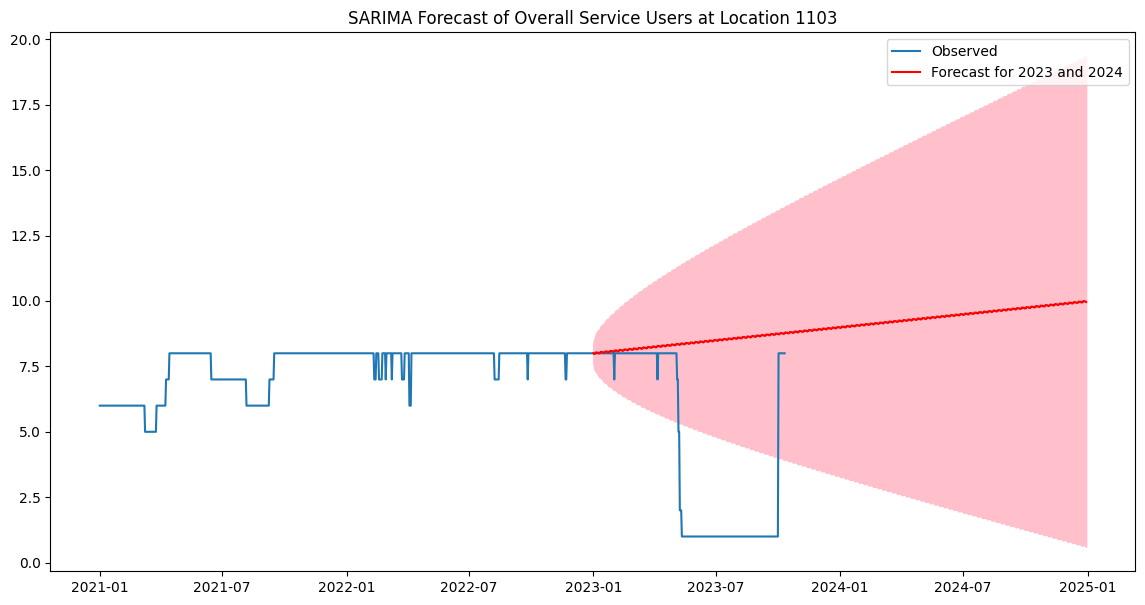

In [40]:
# Define a SARIMA model for the aggregated time series data
# The order parameter specifies the AR, differencing, and MA terms, respectively.
# The seasonal_order parameter adds seasonal terms with a weekly periodicity (specified as 7).
model_overall_users = SARIMAX(aggregated_overall_users, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality assumed

# Fit the SARIMA model to the data.
# The disp=False argument suppresses convergence output for cleaner presentation.
sarima_overall_users_result = model_overall_users.fit(disp=False)

# Forecast the service users for the next 730 days (covering 2023 and 2024).
forecast_overall_users = sarima_overall_users_result.get_forecast(steps=730)

# Extract the mean forecast values from the forecast results.
mean_forecast_overall_users = forecast_overall_users.predicted_mean

# Extract the confidence intervals for the forecast. 
# This provides an upper and lower bound for the forecast, indicating the uncertainty.
confidence_intervals_overall_users = forecast_overall_users.conf_int()

# Set up the figure and axis for plotting with a specified size.
plt.figure(figsize=(14, 7))

# Plot the observed data in blue.
plt.plot(aggregated_overall_users_all_years.index, aggregated_overall_users_all_years, label='Observed')

# Plot the forecasted data in red.
plt.plot(mean_forecast_overall_users.index, mean_forecast_overall_users, color='red', label='Forecast for 2023 and 2024')

# Fill the area between the upper and lower confidence intervals with pink to indicate uncertainty.
plt.fill_between(confidence_intervals_overall_users.index, 
                 confidence_intervals_overall_users.iloc[:, 0], 
                 confidence_intervals_overall_users.iloc[:, 1], color='pink')

# Add a legend to the plot for clarity.
plt.legend()

# Add a title to the plot.
plt.title('SARIMA Forecast of Overall Service Users at Location 1103')

# Display the plot.
plt.show()